Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет www.kaggle.com...iques/data (train.csv)
Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
Построить случайный лес, вывести важность признаков
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Из описания датасета следует, что пустые значения поля Alley значат, что аллеи нет, заменим пустые на 'No_Alley'
data['Alley'] = data['Alley'].fillna('No_Alley')

# пустые значения поля Fence значат, что забора нет, заменим пустые на 'No_Fence'
data['Fence'] = data['Fence'].fillna('No_Fence')

# пустые значения поля PoolQC значат, что бассейна нет, заменим пустые на 'No_Pool'
data['PoolQC'] = data['PoolQC'].fillna('No_Pool')

# пустые значения поля MiscFeature значат отсутствие доп.функций, заменим пустые на 'No_MF'
data['MiscFeature'] = data['MiscFeature'].fillna('No_MF')

# пустые значения поля FireplaceQu значат отсутствие камина, заменим пустые на 'No_FQ'
data['FireplaceQu'] = data['FireplaceQu'].fillna('No_FQ')

# пустые значения полей GarageType, GarageFinish, GarageQual, GarageCond значат отсутствие гаража, заменим пустые на 'No_G'
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('No_G')

# пустые значения полей GarageYrBlt, GarageArea, GarageCars заменим на 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
    
# пустые значения в LotFrontage заменим на медианную ширину улицы в данном районе
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# пустые значения полей BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1,BsmtFinType2 значат отсутствие подвала, заменим на 'No_B'
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('No_B')
    
# пустые значения полей MasVnrArea, MasVnrType заменим площадь на 0, а тип на 'None' 
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

# в Electrical есть одно пустое значение, заменим его модой
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

# Уберем из датасета колонку id, так как она не несет никакой полезной информации
data = data.drop(columns='Id')

Еще раз проверим, есть ли пустые значения

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Пустых значений нет, можно далее продолжать работу с датасетом

In [6]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['SalePrice'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 5 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 5].index)
len(cat_feat)

MSZoning          5
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            4
Fence             5
MiscFeature       5
SaleType          9
SaleCondition     6
dtype: int64


13

In [7]:
# Создаем дамми-переменные для категорий

dummy_ = pd.get_dummies(data[cat_feat], columns=cat_feat)
dummy_cols = list(set(dummy_))
dummy_ = dummy_[dummy_cols]

In [10]:
# Kросс Валидация

X_KF = pd.concat([data[num_feat], dummy_], axis=1)
y_KF = data['SalePrice']

skf = KFold(n_splits=10, shuffle = True, random_state = 1)
test_KF_score = []

# перечисление выборок датасета

for train_index, test_index in skf.split(X_KF, y_KF):
    X_KF_train, X_KF_test = X_KF.iloc[train_index], X_KF.iloc[test_index]
    y_KF_train, y_KF_test = y_KF.iloc[train_index], y_KF.iloc[test_index]
    KF_model = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
    KF_model.fit(X_KF_train, y_KF_train)
    y_KF_pred = KF_model.predict(X_KF_test)
    test_KF_score.append(KF_model.score(X_KF_test, y_KF_test))

# Метрики

print(f'Score: {np.mean(test_KF_score)}')
print('Mean Absolute Error: ', mean_absolute_error(y_KF_test, y_KF_pred))
print('Mean Squared Eerror: ', mean_squared_error(y_KF_test, y_KF_pred, squared=False))
print('Variance Score: ', r2_score(y_KF_test, y_KF_pred))

Score: 0.8051926975748142
Mean Absolute Error:  19281.45659238443
Mean Squared Eerror:  29765.167928014245
Variance Score:  0.8513254866985616


### Случайный лес ###

In [11]:
X_RF = pd.concat([data[num_feat], dummy_], axis=1)
y_RF = data['SalePrice']
X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(X_RF, y_RF, test_size=0.2)

clf_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_RF_train, y_RF_train)

RandomForestRegressor(max_depth=5, max_features=0.5, min_samples_leaf=20,
                      n_estimators=10, n_jobs=-1)

In [12]:
y_RF_pred_train_rf = clf_rf.predict(X_RF_train)
y_RF_pred_test_rf = clf_rf.predict(X_RF_test)

print(f'Score:', clf_rf.score(X_RF_test, y_RF_test))
print('Mean Absolute Error: ', mean_absolute_error(y_RF_test, y_RF_pred_test_rf))
print('Mean Squared Eerror: ', mean_squared_error(y_RF_test, y_RF_pred_test_rf, squared=False))
print('Variance score: ', r2_score(y_RF_test, y_RF_pred_test_rf))

Score: 0.8084142776958545
Mean Absolute Error:  22081.811962547665
Mean Squared Eerror:  34186.276448412296
Variance score:  0.8084142776958545


#### Важность признаков ####

In [16]:
feature_importances = pd.DataFrame(clf_rf.feature_importances_, index=X_RF.columns, 
                                   columns=['importances']).sort_values('importances', ascending=False)
feature_importances

,importances
OverallQual,0.358325
GarageCars,0.200174
GrLivArea,0.127553
ExterQual_TA,0.079618
1stFlrSF,0.045207
...,...
MasVnrType_Stone,0.000000
KitchenQual_Fa,0.000000
LandSlope_Mod,0.000000
LandContour_Low,0.000000


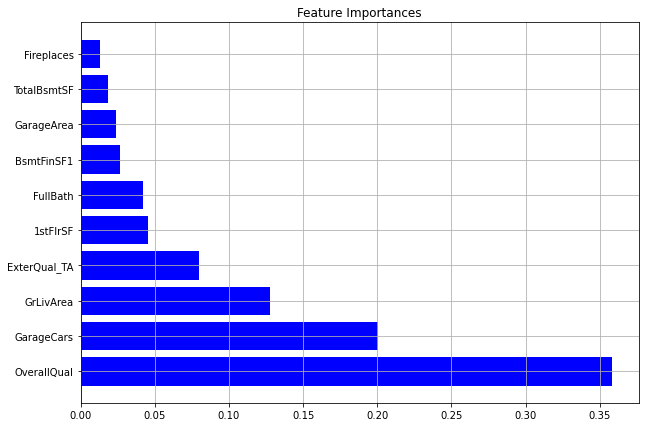

In [15]:
features = X_RF.columns
importances = clf_rf.feature_importances_
indices = np.argsort(importances)
pairs = list(zip(importances[indices], [features[i] for i in indices]))
top10 = sorted(pairs, key=lambda x:x[0], reverse=True)[:10]

plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(top10)), [x[0] for x in top10], color='b', align='center')
plt.yticks(range(len(top10)), [x[1] for x in top10])
plt.grid()
plt.show()

Наиболее важными признаками являются: OverallQual(Общее качество материалов и отделки) и GarageCars (Размер гаража по вместимости машины)

### Объединим модели ###

In [17]:
from sklearn.preprocessing import StandardScaler

X_SR = pd.concat([data[num_feat], dummy_], axis=1)
y_SR = data['SalePrice']

scaler = StandardScaler()
scaler.fit(X_SR)

X = scaler.transform(X_SR)

#### Обучим стекинг ####

In [18]:
X_SR_train, X_SR_test, y_SR_train, y_SR_test = train_test_split(X_SR, y_SR, test_size=0.2)

regressor = StackingRegressor(
    [
        ('kn', KNeighborsRegressor()),
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor())
    ],
RandomForestRegressor())

In [19]:
regressor.fit(X_SR_train, y_SR_train)

StackingRegressor(estimators=[('kn', KNeighborsRegressor()),
                              ('lr', LinearRegression()),
                              ('dt', DecisionTreeRegressor())],
                  final_estimator=RandomForestRegressor())

In [20]:
y_SR_pred_proba_lr = regressor.named_estimators_['lr'].score(X_SR_test, y_SR_test)
y_SR_pred_proba_kn = regressor.named_estimators_['kn'].score(X_SR_test, y_SR_test)
y_SR_pred_proba_dt = regressor.named_estimators_['dt'].score(X_SR_test, y_SR_test)
y_SR_pred_proba = regressor.score(X_SR_test, y_SR_test)

print(y_SR_pred_proba_lr)
print(y_SR_pred_proba_kn)
print(y_SR_pred_proba_dt)
print(y_SR_pred_proba)

0.9025739284857145
0.7148911450275466
0.7605749168621834
0.9028044773805043


In [21]:
regressor.final_estimator_

RandomForestRegressor()

### Сравним Score для разных моделей ###

In [22]:
print('Score for:')
print('KFold_Random Forest:     ', np.mean(test_KF_score))
print('Random Forest:           ', clf_rf.score(X_RF_test, y_RF_test))
print('Stacking:                ', regressor.score(X_SR_test, y_SR_test))

Score for:
KFold_Random Forest:      0.8051926975748142
Random Forest:            0.8084142776958545
Stacking:                 0.9028044773805043


Результат стекинга превышает результаты отдельно взятых моделей